# 13: Introduction to Wine Quality Dataset

### 🎯 Objective
Before we can tune hyperparameters (like learning rates or activation functions), we need a good dataset. This notebook walks through the end-to-end process of preparing a real-world dataset for a Deep Learning model.

### 📚 Key Concepts
- **Data Cleaning:** Removing outliers that could skew the model.
- **Z-Score Normalization:** Scaling features to have a mean of 0 and a standard deviation of 1. This is crucial for ensuring all inputs contribute equally to the gradient.
- **Binarization:** Converting a continuous or ordinal target (scores 3-8) into a binary class (0 or 1) for classification.
- **DataLoaders:** The final step of wrapping processed data for PyTorch.

In [1]:
### import libraries

# for DL modeling
import torch
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Import and Inspect Data

We load the "Red Wine Quality" dataset directly from the UCI Machine Learning Repository.

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

# Load data into a pandas DataFrame
data = pd.read_csv(url,sep=';')

# Show the first few rows
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
# describe the data (get mean, std, min, max for each column)
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
# list number of unique values per column
# This helps us identify categorical vs continuous variables.
# 'quality' is our target label.

for i in data.keys():
  print(f'{i} has {len(np.unique(data[i]))} unique values')

fixed acidity has 96 unique values
volatile acidity has 143 unique values
citric acid has 80 unique values
residual sugar has 91 unique values
chlorides has 153 unique values
free sulfur dioxide has 60 unique values
total sulfur dioxide has 144 unique values
density has 436 unique values
pH has 89 unique values
sulphates has 96 unique values
alcohol has 65 unique values
quality has 6 unique values


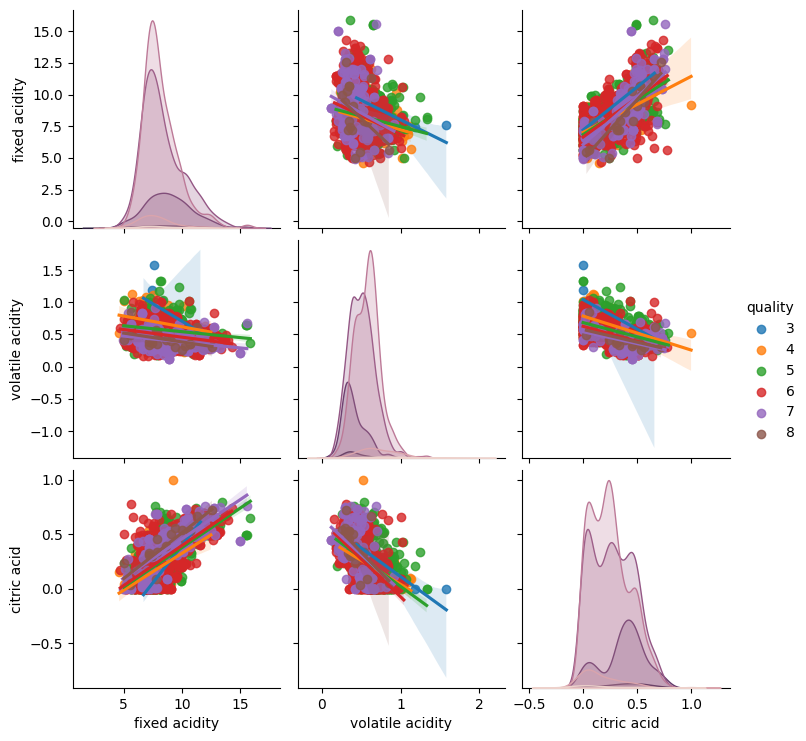

In [5]:
# pairwise plots
# Visualize relationships between a few features and the quality.
cols2plot = ['fixed acidity','volatile acidity','citric acid','quality']
sns.pairplot(data[cols2plot],kind='reg',hue='quality')
plt.show()

## 2. Data Cleaning (Outlier Removal)

Boxplots are excellent for identifying outliers. In the plot below, look at the `total sulfur dioxide` column. There are a couple of points that are way higher than the rest (above 200).

Outliers can distort normalization (checking standard deviation) and confuse the model, so we remove them.

/tmp/ipython-input-642548531.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


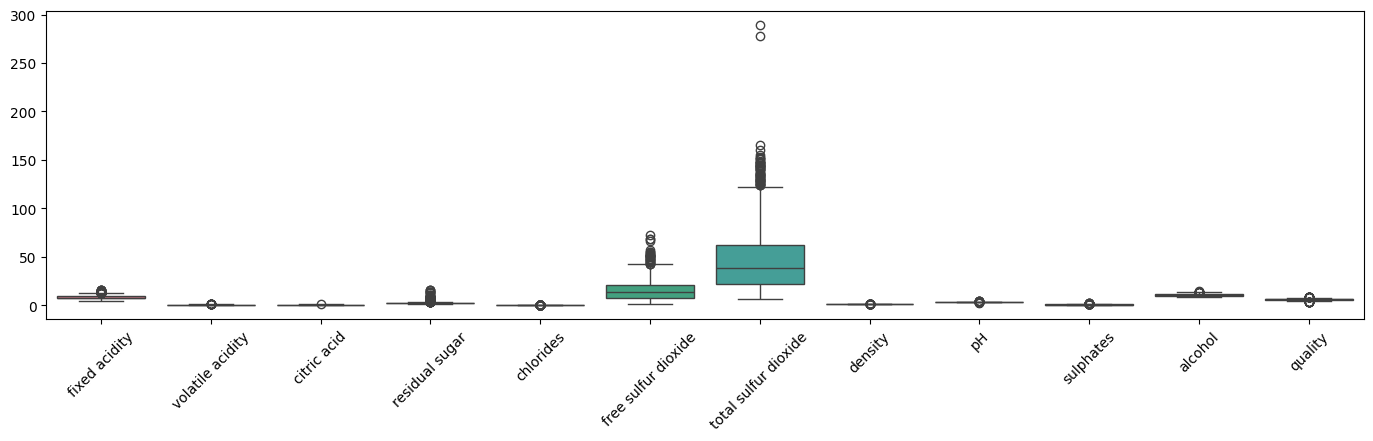

In [6]:
# plot the data boxplots to spot outliers
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()


/tmp/ipython-input-3387013593.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


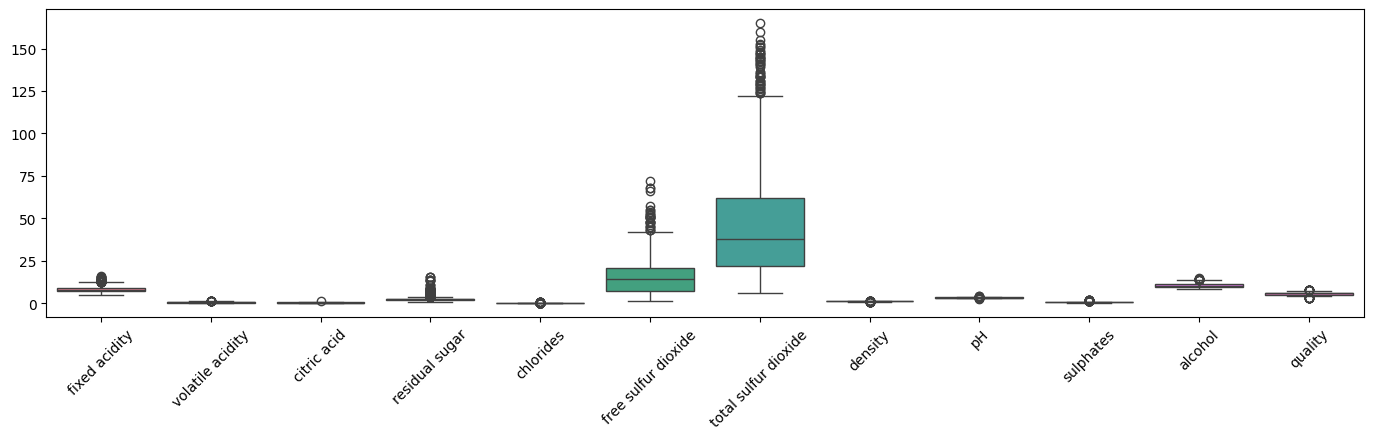

In [7]:
# remove rows where 'total sulfur dioxide' is > 200
data = data[data['total sulfur dioxide']<200]

# plot again to verify
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

## 3. Data Normalization (Z-Score)

Neural networks work best when inputs are on a similar scale (e.g., -2 to +2). 
Currently, `sulfur dioxide` is ~50 while `density` is ~0.99. The model would pay too much attention to the large numbers.

**Solution:** Z-Score Normalization.
$$x' = \frac{x - \mu}{\sigma}$$

**Important:** We normalize the *features*, but we **do not** normalize the *target* label (`quality`).

In [8]:
### z-score all variables except for quality

# find the columns we want to normalize (all except quality)
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')

# z-score (written out step-by-step for clarity)
for col in cols2zscore:
  meanval   = np.mean(data[col])
  stdev     = np.std(data[col],ddof=1)
  data[col] = (data[col]-meanval) / stdev

# Alternative compact way using scipy:
# data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1597.000000
mean,7.118775e-17,1.201293e-16,5.339081e-17,-7.118775e-17,-1.512740e-16,1.779694e-17,-7.118775e-17,-8.350323e-14,2.847510e-16,1.067816e-16,-6.050959e-16,5.634314
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.806630
min,-2.135419e+00,-2.280048e+00,-1.391387e+00,-1.168783e+00,-1.604073e+00,-1.422392e+00,-1.262186e+00,-3.545821e+00,-3.708218e+00,-1.936711e+00,-1.898626e+00,3.000000
25%,-7.003882e-01,-7.715838e-01,-9.283861e-01,-4.524372e-01,-3.720247e-01,-8.476045e-01,-7.594598e-01,-6.109478e-01,-6.585382e-01,-6.390204e-01,-8.650444e-01,5.000000
50%,-2.411785e-01,-4.528645e-02,-5.382836e-02,-2.375335e-01,-1.808448e-01,-1.770192e-01,-2.567340e-01,-6.214425e-04,-9.670044e-03,-2.261189e-01,-2.073106e-01,6.000000
75%,5.050372e-01,6.251419e-01,7.692848e-01,4.900487e-02,5.281955e-02,4.935662e-01,4.973546e-01,5.778618e-01,5.743113e-01,4.227263e-01,6.383472e-01,6.000000
max,4.350918e+00,5.876831e+00,3.753070e+00,9.289866e+00,1.112001e+01,5.379259e+00,3.733652e+00,3.682565e+00,4.532407e+00,7.913939e+00,4.208902e+00,8.000000


/tmp/ipython-input-1345728517.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


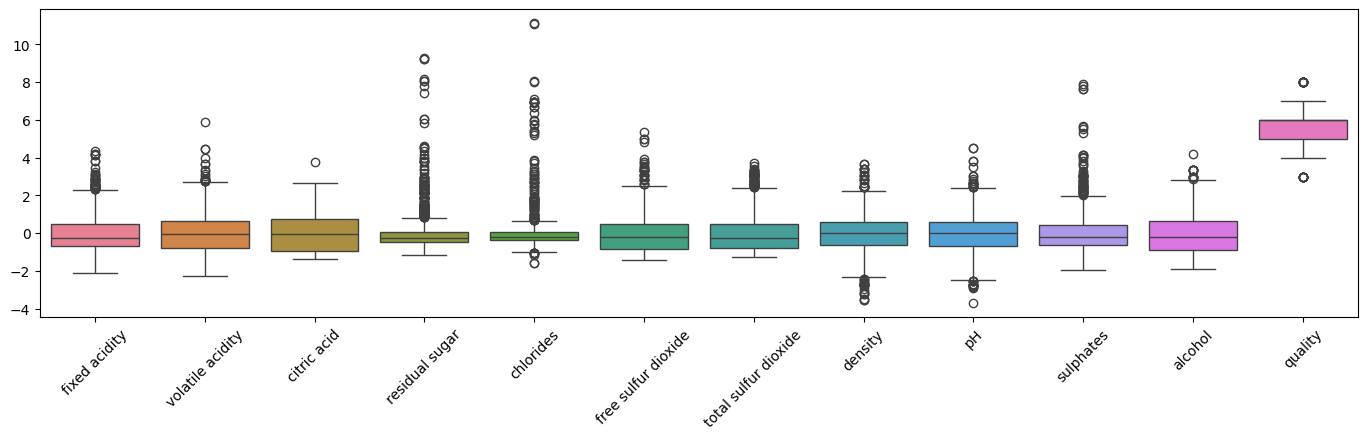

In [9]:
# check the plot again
# Now all boxplots should be centered around 0 with similar spread.
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

## 4. Target Binarization

The `quality` column currently contains integers like 3, 4, 5, 6, 7, 8. 
We want to turn this into a binary classification problem:
- **0 (Low Quality):** Ratings 3, 4, 5
- **1 (High Quality):** Ratings 6, 7, 8

This balances the dataset fairly well.

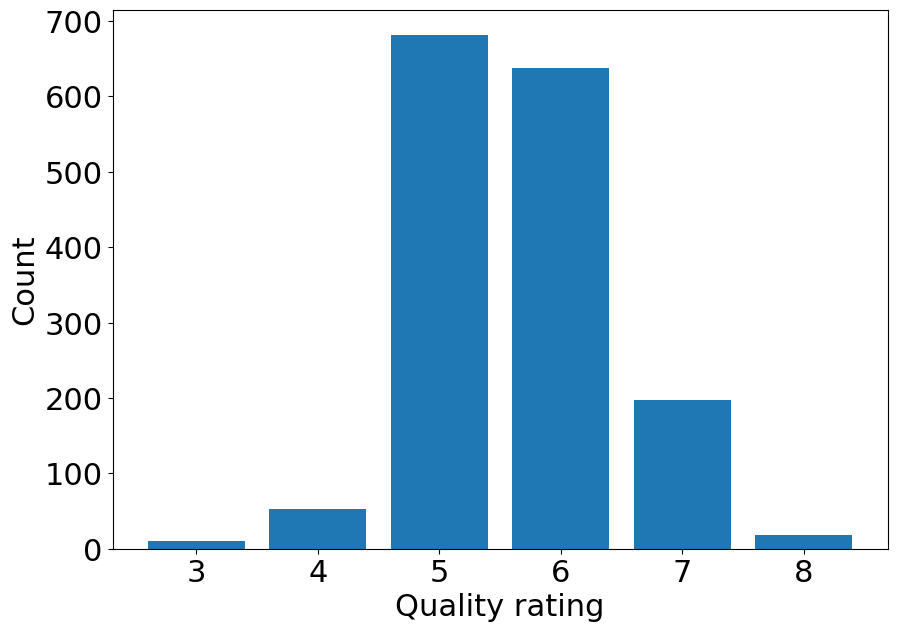

/tmp/ipython-input-2219836168.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>5] = 1
/tmp/ipython-input-2219836168.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

,quality,boolQuality
0,5,0
1,5,0
2,5,0
3,6,1
4,5,0
...,...,...
1594,5,0
1595,6,1
1596,6,1
1597,5,0


In [10]:
# distribution of quality values
fig = plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 22}) # increase font size in the figure

counts = data['quality'].value_counts()
plt.bar(list(counts.keys()),counts)
plt.xlabel('Quality rating')
plt.ylabel('Count')
plt.show()

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0

# Ideally: quality > 5 is "good" (1), quality <= 5 is "bad" (0)
data['boolQuality'][data['quality']>5] = 1

data[['quality','boolQuality']]

## 5. Prepare for PyTorch (DataLoaders)

Now we convert the cleaned, normalized pandas DataFrame into PyTorch tensors, split it into train/test sets, and wrap them in DataLoaders.

In [11]:
# convert from pandas dataframe to tensor
# Note: We select only the normalized columns for input
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()

print( dataT.shape )
print( labels.shape )

# Reshape labels to be 2D tensor (N, 1) instead of 1D vector (N)
labels = labels[:,None]
print( labels.shape )

torch.Size([1597, 11])
torch.Size([1597])
torch.Size([1597, 1])


In [14]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)


# then convert them into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 64
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True, drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [15]:
# check sizes of data batches to ensure everything worked
for X,y in train_loader:
  print(X.shape,y.shape)

# go back and set drop_last=True in training DataLoader if you see a small final batch
# (e.g., if the last batch has only 1 or 2 items)

torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])


In [ ]:
# 1) In a later video, we will use DL to predict residual sugar. Use seaborn to make a histogram of that data column.
#    Spend a minute to explore the visualization options in sns.histplot. For example, you can add a kernel density
#    estimate, make the histogram bars purple, and so on.
#
# 2) (Warning: This exercise is for people who are familiar with statistics.) Loop over all the variables in the dataset,
#    and perform an independent-samples t-test on the data for the binarized wine quality. Which variables are significantly
#    different between "low" and "high" quality wine?
#